<a href="https://colab.research.google.com/github/elizabeamedalla/Capstone-2-Recommendation-System/blob/master/Recommendation_Engine_Surprise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
# Source: https://bmanohar16.github.io/blog/recsys-evaluation-in-surprise

import os
# file compression for loading data
import gzip
# importing json file
import json
# installing
!pip install surprise
#!pip install scikit-surprise # if the first line does not work

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# import ML packages
!pip install surprise

import surprise
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

     |████████████████████████████████| 11.8MB 2.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670915 sha256=978c843578b39e72af85c485dfb0d08ae0cb1bbf50a7f8689e4faab7432ddadf
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# Create Dataframe


## Load Data

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_All_Beauty.json.gz # Metadata
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz # Review Data

### load the meta data
meta = []
reviews = []

# Beauty products metadata
with gzip.open('meta_All_Beauty.json.gz') as f:
    for l in f:
        meta.append(json.loads(l.strip()))

# Beauty products reviews
with gzip.open('All_Beauty.json.gz') as f:
    for l in f:
        reviews.append(json.loads(l.strip()))

# information about the products
df_meta = pd.DataFrame.from_dict(meta)

# user reviews on each products
df_reviews = pd.DataFrame.from_dict(reviews)

# Reset meta and reviews array
meta = None
reviews = None

--2020-10-03 16:21:31--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10032305 (9.6M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.57M  14.8MB/s    in 0.6s    

2020-10-03 16:21:32 (14.8 MB/s) - ‘meta_All_Beauty.json.gz’ saved [10032305/10032305]

--2020-10-03 16:21:32--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47350910 (45M) [application/octet-stream]
Saving to: ‘All_Beauty.json.gz’

All_Beauty.json.gz  100%[===================>]  45.16M  31.1MB/s    in 1.

## Clean Data

In [ ]:
#drop duplicates
df_meta = df_meta.drop_duplicates('asin', keep="first")

# filling the NaN values
df_reviews = df_reviews.fillna('NaN')

## remove rows with unformatted title (i.e. some 'title' may still contain html style content)
df_meta = df_meta.fillna('NaN')

# converting to 'reviewTime' to datetime format
df_reviews['reviewTime'] = pd.to_datetime(df_reviews['reviewTime'])
df_reviews['unixReviewTime'] = pd.to_datetime(df_reviews['unixReviewTime'],unit='s')

# merging 2 df together and selecting only relevant columns
data = pd.merge(df_reviews, df_meta, on='asin', sort='reviewTime')
data = data.drop(columns=['style', 'image_x', 'image_y', 'feature', 'tech1', 'date', 'unixReviewTime'])

# renaming columns
rename_dict = {
    "overall": "rating", 
    "asin": "product_id",
    "reviewTime": "review_time",
    "reviewerID": "reviewer_id",
    "reviewerName": "reviewer_name",
    "reviewText": "reviewer_text"  
}

data = data.rename(columns=rename_dict)
# Selecting columns to be used
data = data[['rating', 'reviewer_id', 'product_id', 'title']]

# Uncomment if RAM crashes
# # Reset df_reviews and df_meta
# # df_reviews = None
# # df_meta = None

data.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366223 entries, 0 to 366222
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   rating       366223 non-null  float64
 1   reviewer_id  366223 non-null  object 
 2   product_id   366223 non-null  object 
 3   title        366223 non-null  object 
dtypes: float64(1), object(3)
memory usage: 101.4 MB


Reduce memory usage of data by changing the dtype
https://pythonspeed.com/articles/pandas-load-less-data/

In [ ]:
# Shrink 'rating' column with smaller dtypes
data['rating'] = data['rating'].astype('int8')
# Converting object dtypes to string
data['reviewer_id'] = data['reviewer_id'].astype('string')
data['product_id'] = data['product_id'].astype('string')
data['title'] = data['title'].astype('string')
data.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366223 entries, 0 to 366222
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   rating       366223 non-null  int8  
 1   reviewer_id  366223 non-null  string
 2   product_id   366223 non-null  string
 3   title        366223 non-null  string
dtypes: int8(1), string(3)
memory usage: 98.9 MB


Filter the dataset to include only the top 20k reviewers

In [ ]:
# Get top 20k reviewers
num_reviewers = 20000
top_reviewers = list(data.reviewer_id.value_counts().head(num_reviewers).index)
data = data[data['reviewer_id'].isin(top_reviewers)]

# Reset top_reviewers
top_reviewers = None

data.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50988 entries, 1 to 366222
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rating       50988 non-null  int8  
 1   reviewer_id  50988 non-null  string
 2   product_id   50988 non-null  string
 3   title        50988 non-null  string
dtypes: int8(1), string(3)
memory usage: 13.2 MB


# Inspect Data

## Basic Statistics of the Filtered Data

In [ ]:
data.head()

,rating,reviewer_id,product_id,title
1,1,A1OMHUU58XHQNG,6546546450,Loud 'N Clear&trade; Personal Sound Amplifier
13,4,A1TZ1QV2QD7QZV,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...
20,5,AA0ACUPEPT1RN,7535842801,Mary Kay Satin Hands Hand Cream Travel MINI Si...
51,5,A2DKXR9XDNA44Q,9197882747,Hall of Femmes: Lella Vignelli (Hall of Femmes)
57,5,A3QQK2K2BEJRQ,9742121109,Estee Lauder Resilience Lift Night Firming/scu...


In [ ]:
print('No. of Unique Users    :', data.reviewer_id.nunique())
print('No. of Unique Items :', data.product_id.nunique())
print('No. of Unique Ratings  :', data.rating.nunique())

No. of Unique Users    : 20000
No. of Unique Items : 8338
No. of Unique Ratings  : 5


In [ ]:
data.describe()

,rating
count,50988.000000
mean,4.337707
std,1.163072
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Overall Count of Ratings given by Users

In [ ]:
rts_gp = data.groupby(by=['rating']).agg({'reviewer_id': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']
rts_gp

,Rating,Count
0,1,3138
1,2,2084
2,3,3704
3,4,7557
4,5,34505


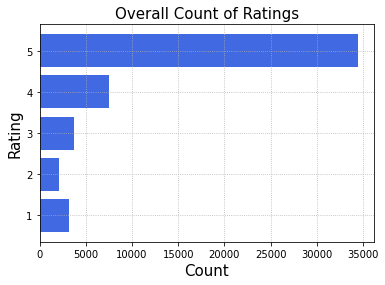

In [ ]:
plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

# Machine Learning

We're going to use models commonly applied for classification problems.

In [ ]:
# As we're loading a custom dataset, we need to define a reader. (Surprise way of encoding the data)
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
surprise_data = Dataset.load_from_df(data[['reviewer_id', 'product_id', 'rating']], reader)

## Evaluation with various Algorithms available in Surprise

**k-NN Based Algorithms:** *KNNBasic, KNNWithMeans and KNNWithZScore*

**Matrix Factorization Based Algorithms:** *SVD, SVDpp and Non-Negative Matrix Factorization (NMF)*

**Other Collaborative Filtering Algorithms:**: *SlopeOne, CoClustering*

**Cross Validation**: 5-Fold

**Optimization Metric:** RMSE

### k-NN Based Algorithms

For the memory-based approaches, the algorithm that would fit the bill is Centered k-NN because the algorithm is very close to the centered cosine similarity formula.

In [ ]:
# cross-validation for KNN Basic
knnbasic_cv = cross_validate(KNNBasic(), surprise_data, cv=5, n_jobs=1, verbose=False)
# cross-validation for KNN Means
knnmeans_cv = cross_validate(KNNWithMeans(), surprise_data, cv=5, n_jobs=1, verbose=False)
# cross-validation for KNN with Z-score
knnz_cv = cross_validate(KNNWithZScore(), surprise_data, cv=5, n_jobs=1, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### Matrix Factorization Based Algorithms

For model-based algorithms, we are going to use SVD(), SVDpp() and NMF. Singular Value Decomposition (SVD) is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler. 

In [ ]:
# cross-validation for SVD
svd_cv = cross_validate(SVD(), surprise_data, cv=5, n_jobs=1, verbose=False)
# cross-validation for SVDpp
svdpp_cv = cross_validate(SVDpp(), surprise_data, cv=5, n_jobs=1, verbose=False)
# cross-validation for Non-Negative Matrix Factorization (NMF)
nmf_cv = cross_validate(NMF(), surprise_data, cv=5, n_jobs=1, verbose=False)

### Other Collaborative Filtering Algorithms

In [ ]:
# cross-validation for SlopeOne
slope_cv = cross_validate(SlopeOne(), surprise_data, cv=5, n_jobs=1, verbose=False)
#cross-validation for Co-clustering
coclus_cv = cross_validate(CoClustering(), surprise_data, cv=5, n_jobs=1, verbose=False)

### Comparison of all algorithms on RMSE and MAE

In [ ]:
# Get the scores for each Vanilla version of the models
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 0.9345 	 0.5364
KNN Means 	 1.0086 	 0.5204
KNN ZScore 	 1.008 	 0.5231

SVD 		 0.9649 	 0.6663
SVDpp 		 0.9602 	 0.6581
NMF 		 1.1249 	 0.804

SlopeOne 	 1.0087 	 0.511
CoClustering 	 1.0504 	 0.6144



### Plot the Error Scores

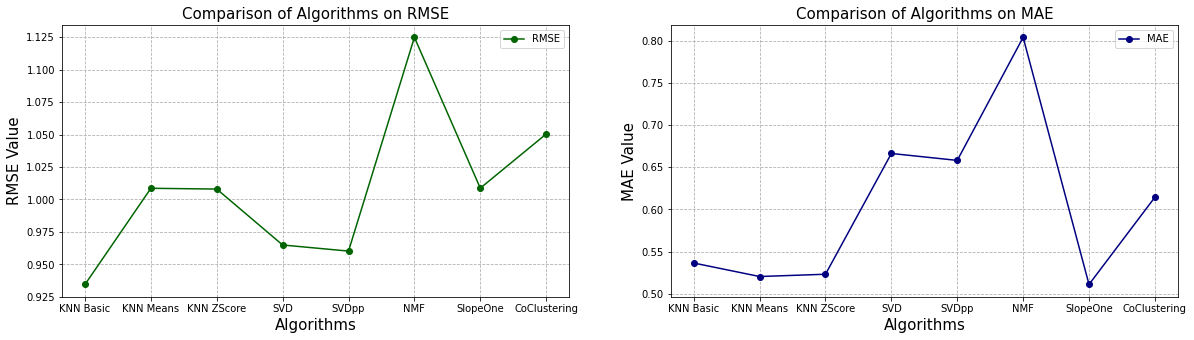

In [ ]:
# Plot the scores

x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()


### Evaluation Results

We will use RMSE score as our metric for our accuracy score. RMSE punishes more larger errors the same while MAE only punishes every error.

**RMSE**:
 - Winner: KNN Basic (0.9372)
 - 2nd place: SVDpp (0.9576)
 - 3rd place: SVD (0.9698)

**MAE**:
 - Winner: KNN with means (0.5175)
 - 2nd place: KNN with Zscore (0.5207)
 - 3rd place: KNN Basic (0.5394)



## Perform GridSearch CV on top three algorithms - KNN Basic, SVDpp and SVD 

### Hypertuning SVDpp and SVD

In [ ]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

# Loop through predefined hyperparameters for SVDpp
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
# Fit your estimator (model) on the training set
svdpp_gs.fit(surprise_data)

# Loop through predefined hyperparameters for SVD
svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
# Fit your estimator (model) on the training set
svd_gs.fit(surprise_data)

In [ ]:
# SVDpp accuracy score and best parameters
print('SVDpp = RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])


SVDpp = RMSE: 1.0157 ; MAE: 0.7362
RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


In [ ]:
# SVD accuracy score and best parameters
print('SVD = RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

SVD = RMSE: 1.0097 ; MAE: 0.7312
RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


### Hypertuning KNNBasic, KNNWithMeans, KNNZScore

Due to RAM issues, we will only run the KNNBasic()

In [ ]:
# Selecting the K-neighbors
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}


# Loop through each K-neighbors
knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=1)
# Train the model on the train set
knnbasic_gs.fit(surprise_data)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:
x = [15, 20, 25, 30, 40, 50, 60]
y1 = knnbasic_gs.cv_results['mean_test_rmse']

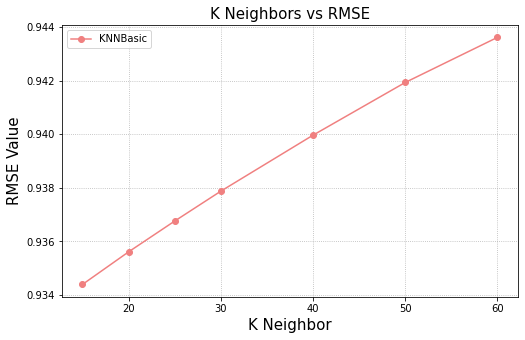

In [ ]:
# Plot the RMSE scores for each K in KnnBasic
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()


### Print out the best model and scores

In [ ]:
print('KNN Basic = RMSE:', round(knnbasic_gs.best_score['rmse'], 4), '; MAE:', round(knnbasic_gs.best_score['mae'], 4))
print('SVDpp = RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD = RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))


KNN Basic = RMSE: 0.9344 ; MAE: 0.5261
SVDpp = RMSE: 1.0157 ; MAE: 0.7362
SVD = RMSE: 1.0097 ; MAE: 0.7312


The best performing model is the KNN basic with an RMSE score of 0.9339 and MAE of 0.5276

### Get the best parameter for KNN Basic

In [ ]:
print(knnbasic_gs.best_params['rmse'])

{'k': 15}


## Apply Hypertuned Model

Comment this out to choose which model to use.

For best parameters:



*   KNNBasic(k = 15)
*   SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)



In [ ]:
# best parameters for knn basic is k=15
algo = KNNBasic(k = 15)

In [ ]:
# # best parameters for SVDpp (we already hypertuned this)
# algo = SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)

### Create a train set and test set

In [ ]:
# As we're loading a custom dataset, we need to define a reader.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
surprise_data = Dataset.load_from_df(data[['reviewer_id', 'product_id', 'rating']], reader)

In [ ]:
# Split the data into train and validation set
trainset, testset = train_test_split(surprise_data, test_size=0.2)
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  19451 

Number of items:  7340 



### Train the model on the train set

In [ ]:
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### Test the model on the test set

In [ ]:
predictions = algo.test(testset)

In [ ]:
predictions[:10]

[Prediction(uid='A3PZARP3I8BWZH', iid='B00STURRUO', r_ui=5.0, est=4.337778867369454, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ASCS6MNT06EG3', iid='B0013J90AS', r_ui=5.0, est=5, details={'actual_k': 15, 'was_impossible': False}),
 Prediction(uid='AX6WUQ0AN080R', iid='B01ALFOC0W', r_ui=5.0, est=4.337778867369454, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='A2JEYPE7344UAT', iid='B0014SQQ3M', r_ui=5.0, est=4.337778867369454, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A39M4GS55JCQCM', iid='B000FOI48G', r_ui=5.0, est=5, details={'actual_k': 15, 'was_impossible': False}),
 Prediction(uid='AQ4CVUUMW9ZZC', iid='B00MQTR48E', r_ui=1.0, est=4.337778867369454, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='AV3S23LM21YGM', iid='B014VQ890G', r_ui=4.0, est=4.337778867369454, details={'was_impossible': True, 'reason': 

### Get the predictions

We'll have to create a function to get the recommended product and its rating that was not reviewed by the user

In [ ]:
def custom_get_predictions(user_id, num_predictions): 

  # all the unique product_id values 
  iids = data['product_id'].unique()

  # get every product_id reviewed by the user
  iids_rated_by_user = data.loc[data['reviewer_id'] == user_id, 'product_id']

  # get the product_ids that were not reviewed by the user
  iids_to_predict = np.setdiff1d(iids, iids_rated_by_user)

  # For this we have to create another dataset with the iids we want to predict 
  # in the sparse format as before of: uid, iid, rating. 
  
  # We'll just arbitrarily set all the ratings of this test set to 4,
  # as they are not needed. Let's do this, then output the first prediction.
  testset = [[user_id, iid, 4] for iid in iids_to_predict]
  
  # Test the algorithm and get the predictions
  predictions = algo.test(testset)
  
  # Gets the number of predictions wanted
  neg_num_predictions = num_predictions * -1

  # Gets just the rating estimate 
  pred_ratings = np.array([pred.est for pred in predictions])

  # # Find the index of the highest predicted rating
  i_max = np.argpartition(pred_ratings, neg_num_predictions)[neg_num_predictions:]
  
  # Use this to find the corresponding iid to recommmed
  iids = iids_to_predict[i_max]

  for i in range(len(iids)):
    iid = iids[i]
    item_title = df_meta.loc[df_meta.asin == iid, "title"].values[0]
    print('#{0} ({1}) recommendation for user A2GJX2KCUSR0EI is {2}: {3}'.format(i, pred_ratings[i_max[i]], iid, item_title))



In [ ]:
# Apply the function we created from the test set
reviewer = testset[0][0]
print("Getting predictions for reviewer:", reviewer)
custom_get_predictions(reviewer, 5)

Getting predictions for reviewer: A3PZARP3I8BWZH
#0 (5.0) recommendation for user A2GJX2KCUSR0EI is B01C4ZAPGM: IntiMD COOCHY PLUS Intimate Shave Cream Gel Rash-Free With MOISTURIZING+ 8oz Squeeze Bottle
#1 (5.0) recommendation for user A2GJX2KCUSR0EI is B00NE5Q9JO: Andalou Naturals 1000 Roses Soothing Body Lotion, 8 Ounce
#2 (5.0) recommendation for user A2GJX2KCUSR0EI is B01CRSWZAU: Bona Fide Beauty Czech Glass Nail Files, Pearl Black Red Color Combination, Medium Size,
#3 (5.0) recommendation for user A2GJX2KCUSR0EI is B00JGZNL4W: MasksCraft by Zappbo&reg; Best White Polka Dot Black Silk Mask with Carry Pouch for Men and Ladies of All Ages and All Shift Works - 100% Money Back Guarantee - Best Contoured Concave Sleeping Eye Mask Light As a Feather for Sleeping and Relaxation. The color is Black and the Convex Cup Shaped Mask is Essential for tight fit on the face to prevent light from coming in. Also cute and best for Novelty, Kids, Children, Teens and Women.
#4 (5.0) recommendation